In [77]:
# Mercari Price Suggestion Challenge

# 중고 시장 내 가격 왜곡이 존재하는가?
# 동일 조건인데 가격편차가 큰 상품군 찾기 ex) “초과가격 vs 저평가 상품 분석”
# = 같은제품이라도 금액이 다른것이나, 컨디션에따른 금액 차이 등을 비교해보려 했으나 아이디어 고갈로 실패

# 제목에 다양한 정보가 포함되어 있으면 가격을 높게 받을 수 있을까?
# = 다양한 정보에 대한 기준을 어떻게 판별해야될지 고민 => 글자수에맞춰서 가격비교.

# 적절한 카테고리를 지정해주는게 가격에 영향이 있을까?
# = 카테고리나, 정보의 유무가 가격과 영향을 미치는지 확인. => O

# item_condition_id : 1~5 (1 = New, 5 = Poor)
# shipping : 0 = buyer pay, 1 = seller pay

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

In [79]:
train_df = pd.read_csv('train.tsv', sep='\t') #분석에 사용할 데이터.
test_df1 = pd.read_csv('test.tsv', sep='\t') #종속변수(y)값 예측하는 모델을 만든 후, 적용 할 데이터.

In [80]:
print(train_df.shape)

train_df.tail()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,NaN,22.0,0,"New with tag, red with sparkle. Firm price, no..."


In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [82]:
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [83]:
train_df.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64

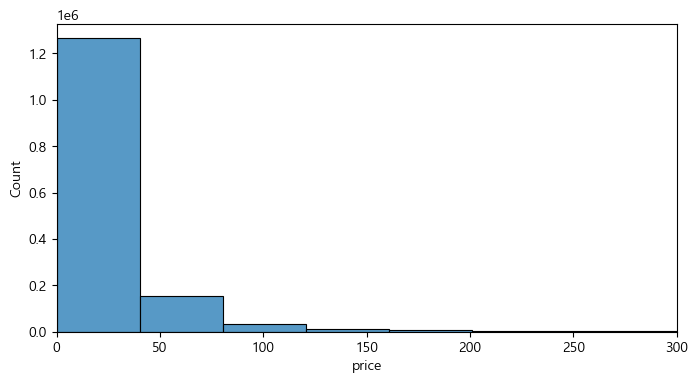

In [84]:
## 1. 금액의 분포에 대해서 파악했음.

plt.figure(figsize=(8, 4))
sns.histplot(train_df['price'], bins=50)
plt.xlim(0, 300)
plt.show()


#대부분의 제품이 5000엔 이하로 몰려있으며 고가의 상품은 매우 극소수로 존재함.
#긴 꼬리형태 모델은 회귀모델에 적합하지 않음. 히스토그램 log로 변환.

In [85]:
train_df['log_price'] = np.log1p(train_df['price']) #log_price = in(price+1)

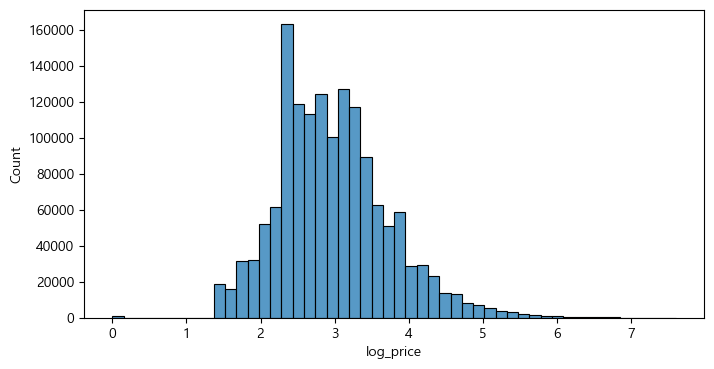

In [86]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['log_price'], bins=50)
plt.show()

#log_price = 2.5와 log_price = 3.5 사이에 위치하므로 11~32달러 사이의 금액이 많은 비중을 차지함을 알 수 있다.

In [87]:
#1. 카테고리나 브랜드의 결측치에 따른 금액예상.  
# - 카테고리를 어떻게 나눌지에 대한 목표를 설정. -> 결측에 따른 카테고리를 만들고, 카테고리를 자동적으로 넣어준다. -> 카테고리의 결측에따라 금액이 차이가 있다면 유의미한 서비스일 수 있음.
# => 결론 : 결측에 따라 금액차이는 있다는것을 알아냈지만, 자동적으로 카테고리를 어떻게 넣어줘야할지 모르겠음.?? 

#2. 카테고리를 men women kids로 나누고 여성이 거래가 많을것으로 예측 -> 예측결과가 맞다면, 중고옷매장등이나 중고장난감가게등과 협업하여 사업을 확장시킬 수 있음.
# - 이번 프로젝트에서는 이 부분은 마지막에 따로 개인적으로 진행해보기로 함.
# => 결론 : 키즈 뷰티 우먼이 70%를 차지하는것을 볼 수 있었음.

#3. 메루카리 시스템 자체가 거래가 많을수록 거래금액에 따른 수수료를 받음 // 현재 상품들은 대다수가 10~35달러정도의 가격을 형성중
# - 새로운 아이템 유입을 위해, 거래금액이 50달러 이상인 제품은 배송수수료를 제외해주는 서비스 등을 제공했을때 더 많은 이익이 생길 수 있다고 생각함. -> 특이사항 유무에 대해 확인할 필요가 있음.
# - or 10~35달러 사이의 제품을 많이 판매할 수록 이익이 생김 -> 
# => 결론 : 특이사항이 없었음.

In [88]:
# 카테고리를 "/" 를 기준으로 split한 값을 컬럼으로 생성

train_df['category_name'] = train_df['category_name'].fillna('Unknown')

train_df['category_split'] = train_df['category_name'].str.split('/')

train_df['category_first'] = train_df['category_split'].str[0]

train_df['category_second'] = train_df['category_split'].str[1]

train_df['category_third'] = train_df['category_split'].str[2]

train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,category_split,category_first,category_second,category_third
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,"[Men, Tops, T-shirts]",Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,"[Electronics, Computers & Tablets, Components ...",Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,"[Women, Tops & Blouses, Blouse]",Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,"[Home, Home Décor, Home Décor Accents]",Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,"[Women, Jewelry, Necklaces]",Women,Jewelry,Necklaces


In [89]:
train_df['category_first'] = train_df['category_first'].astype(str).str.lower()
train_df['category_second'] = train_df['category_second'].astype(str).str.lower()
train_df['category_third'] = train_df['category_third'].astype(str).str.lower()

train_df['category_first'] = train_df['category_first'].str.replace("'s", "", regex=False)
train_df['category_second'] = train_df['category_second'].str.replace("'s", "", regex=False)
train_df['category_third'] = train_df['category_third'].str.replace("'s", "", regex=False)

In [90]:
#각 속성별 컬럼의 갯수.
print(train_df['category_first'].nunique())

print(train_df['category_second'].nunique())

print(train_df['category_third'].nunique())

11
114
870


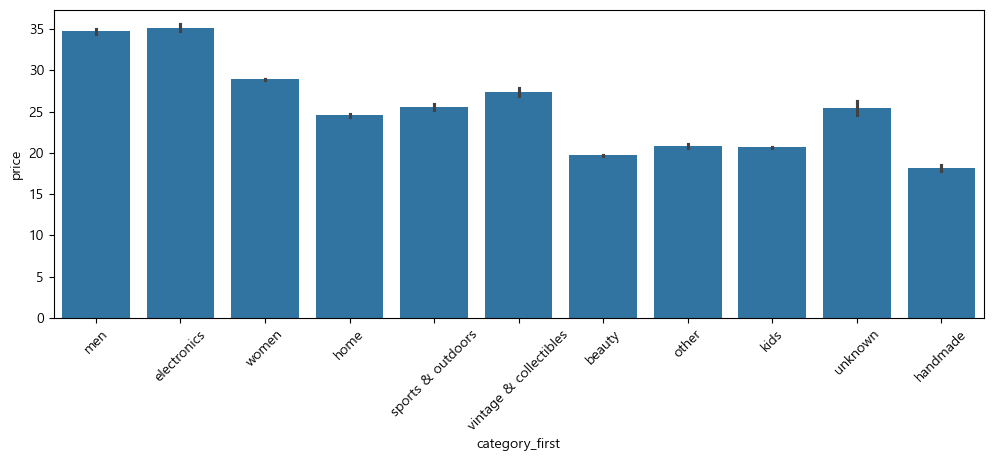

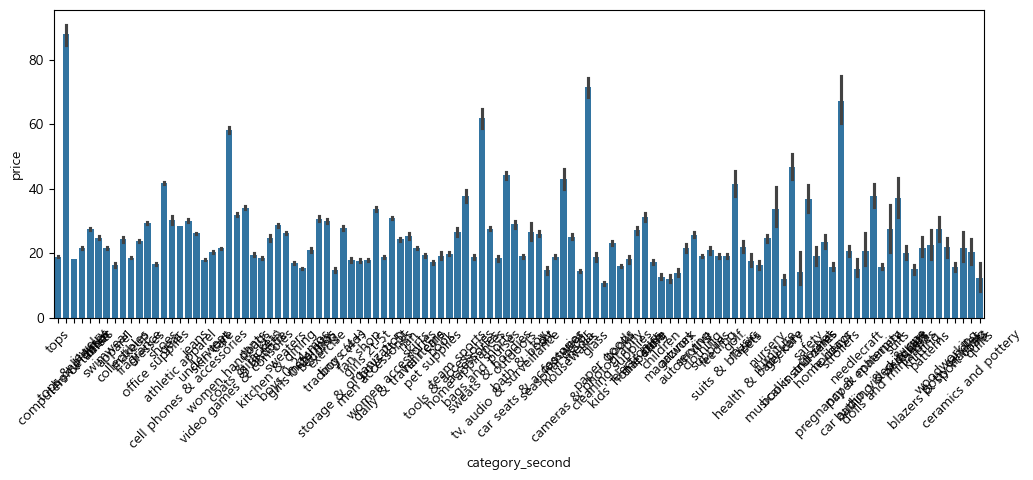

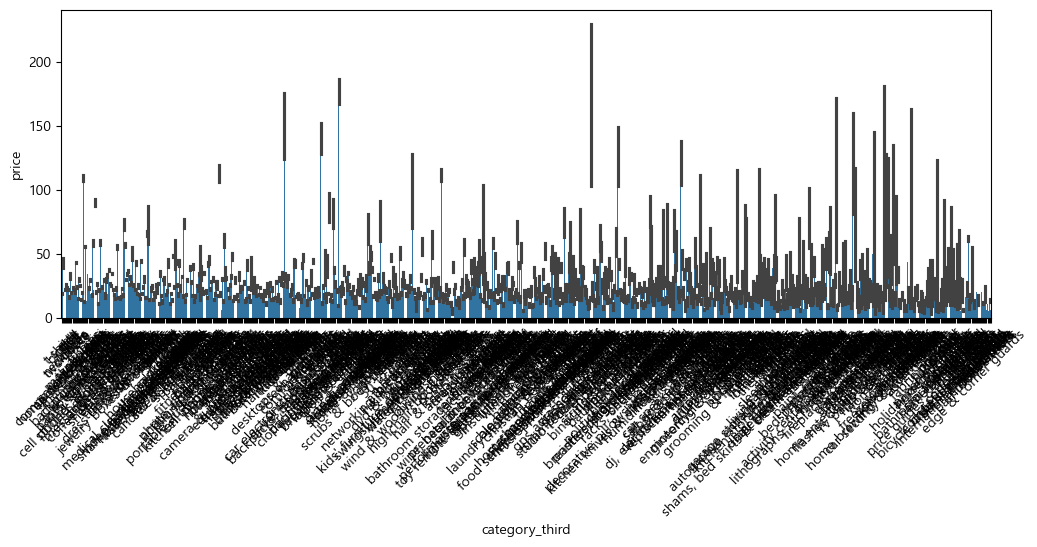

In [91]:
#카테고리별에 따른 금액 비교
plt.figure(figsize=(12,4))
sns.barplot(x=train_df['category_first'], y=train_df['price'])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x=train_df['category_second'], y=train_df['price'])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x=train_df['category_third'], y=train_df['price'])
plt.xticks(rotation=45)
plt.show()

In [92]:
#33달러 이상의 제품의 카테고리를 분류해봄.

high_price_df = train_df[train_df['price'] >= 33]

print(high_price_df.shape)
high_price_df.head()

(315613, 13)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,category_split,category_first,category_second,category_third
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,"[Electronics, Computers & Tablets, Components ...",electronics,computers & tablets,components & parts
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,"[Home, Home Décor, Home Décor Accents]",home,home décor,home décor accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,"[Women, Jewelry, Necklaces]",women,jewelry,necklaces
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",4.094345,"[Women, Other, Other]",women,other,other
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,4.174387,"[Women, Swimwear, Two-Piece]",women,swimwear,two-piece


In [93]:
high_price_df.groupby('category_first')['price'].mean().sort_values(ascending=False).head(20)

category_first
electronics               104.222944
vintage & collectibles     81.029357
men                        73.186047
handmade                   67.574138
unknown                    67.079333
sports & outdoors          66.685697
women                      65.864994
other                      65.583193
kids                       60.929044
home                       57.445206
beauty                     55.407160
Name: price, dtype: float64

In [94]:
high_price_df.groupby('category_second')['price'].mean().sort_values(ascending=False).head(20)

category_second
computers & tablets          141.154697
cell phones & accessories    130.121970
bags and purses              121.112629
cameras & photography        113.023746
strollers                    110.262745
women handbags               101.257733
golf                          87.176895
home appliances               81.644670
musical instruments           81.245399
patterns                      81.111111
tv, audio & surveillance      80.381891
jewelry                       79.144797
video games & consoles        78.739563
safety                        76.379310
men accessories               75.453161
women accessories             74.757732
books and zines               74.500000
car seats & accessories       74.424731
crochet                       73.545455
paper goods                   72.505300
Name: price, dtype: float64

In [95]:
high_price_df.groupby('category_third')['price'].mean().sort_values(ascending=False).head(20)

#상식적으로 비싼 카테고리는 비싸다. 유의미한 결과를 얻지는 못했음.

category_third
tires & wheels                 286.666667
tag                            275.000000
music                          260.500000
laptops & netbooks             220.622413
handbag                        199.228916
desktops & all-in-ones         185.789474
standard                       185.384615
felted                         163.000000
brass instruments              162.300000
cell phones & smartphones      152.384811
digital cameras                150.434280
travel systems                 147.716216
75 to 100 years                144.357143
laptop                         143.466667
clutch                         139.125000
band & orchestra               137.500000
air conditioners               135.378378
flashes & flash accessories    135.200000
satchel                        133.997864
vacuums & floor care           132.100775
Name: price, dtype: float64

In [96]:
#brand/category 결측 여부를 컬럼으로 만들어 금액과 비교.

train_df['brand_missing'] = train_df['brand_name'].isna().astype(int)
train_df['category_missing'] = (train_df['category_name'] == 'Unknown').astype(int)

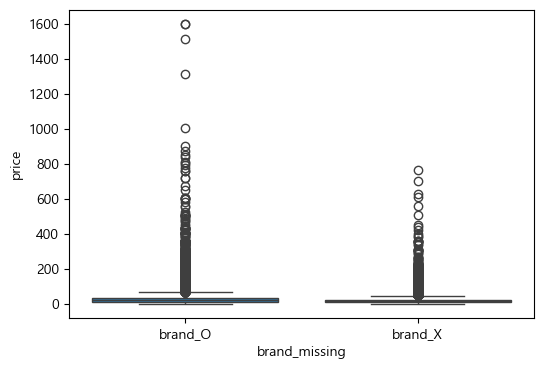

In [97]:
plt.figure(figsize=(6,4))
sns.boxplot(x='brand_missing', y='price', data=train_df.sample(50000, random_state=42))
plt.xticks([0,1], ['brand_O', 'brand_X'])
plt.show()

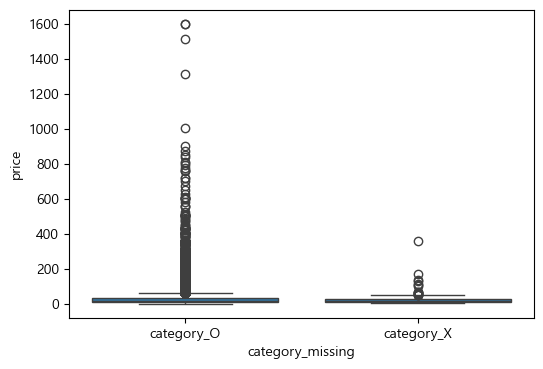

In [98]:
plt.figure(figsize=(6,4))
sns.boxplot(x='category_missing', y='price', data=train_df.sample(50000, random_state=42))
plt.xticks([0,1], ['category_O', 'category_X'])
plt.show()

#브랜드나 카테고리명이 있을때 더 큰 값들이 존재하며 유의미한 결과를 얻을 수 있었음.

In [99]:
print(train_df['category_first'].unique())
print(train_df['category_second'].unique())
print(train_df['category_third'].unique())

['men' 'electronics' 'women' 'home' 'sports & outdoors'
 'vintage & collectibles' 'beauty' 'other' 'kids' 'unknown' 'handmade']
['tops' 'computers & tablets' 'tops & blouses' 'home décor' 'jewelry'
 'other' 'swimwear' 'apparel' 'collectibles' 'makeup' 'fragrance'
 'dresses' 'office supplies' 'shoes' 'gear' 'athletic apparel'
 'cell phones & accessories' 'jeans' 'underwear' 'skin care' 'toys'
 'women handbags' 'video games & consoles' 'coats & jackets' 'pants'
 'girls (4+)' 'antique' 'kitchen & dining' 'sweaters' 'boys 0-24 mos'
 'girls 0-24 mos' 'maternity' 'bedding' 'exercise' 'trading cards'
 'boys (4+)' 'storage & organization' 'fan shop' 'girls 2t-5t'
 'men accessories' 'boys 2t-5t' 'women accessories' 'daily & travel items'
 'nan' 'skirts' 'hair care' 'pet supplies' 'book' 'tools & accessories'
 'team sports' 'home appliances' 'accessories' 'bags and purses'
 'sweats & hoodies' 'shorts' 'tv, audio & surveillance' 'outdoors'
 'bath & body' 'car seats & accessories' 'toy' 'art' 'sea

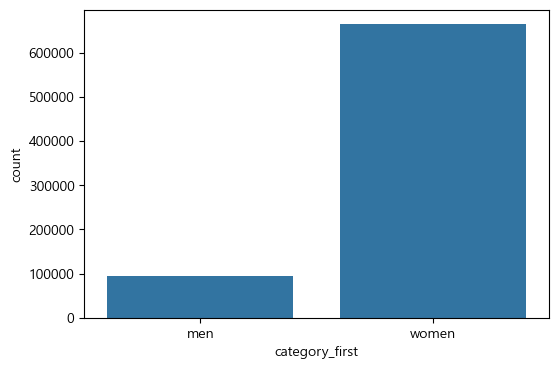

category_first
men      34.708614
women    28.885496
Name: price, dtype: float64

In [100]:
#첫번째 카테고리를 남성과 여성기준으로 나눠서 확인.

gender_df = train_df[train_df['category_first'].isin(['women', 'men'])]

plt.figure(figsize=(6,4))
sns.countplot(x='category_first', data=gender_df)
plt.show()

gender_df.groupby('category_first')['price'].mean()

#유의미한 결과가 나지 않음.

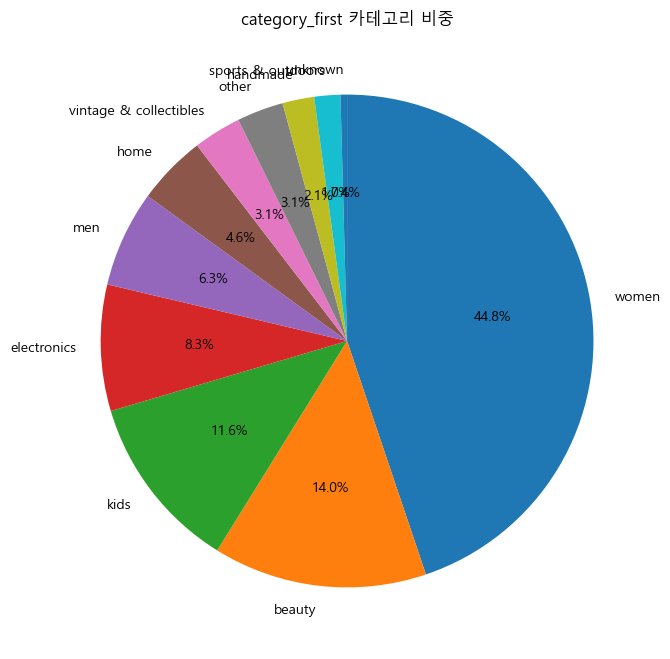

In [101]:
# category_first 비중 계산

cat_first_ratio = train_df['category_first'].value_counts()  # 상위 10개만

plt.figure(figsize=(8,8))
plt.pie(
    cat_first_ratio.values,
    labels=cat_first_ratio.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('category_first 카테고리 비중')
plt.show()

#kids, beauty, women이 70% 비중차지.

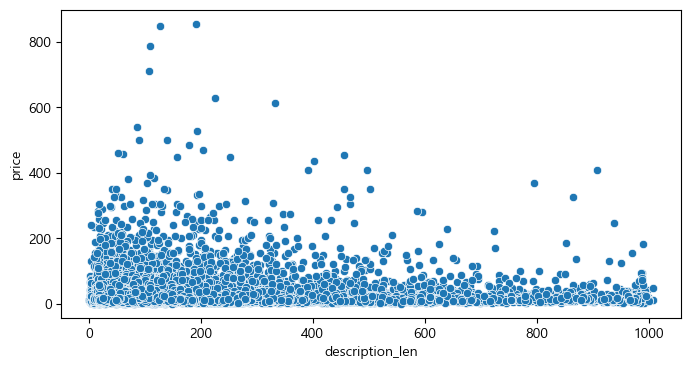

In [109]:
#설명의 길이가 가격의 분포와 연관이 있는지

train_df['description_len'] = train_df['item_description'].fillna('').str.len()

plt.figure(figsize=(8,4))
sns.scatterplot(x='description_len', y='price', data=train_df.sample(20000))
plt.show()

#크게 연관없기에 다른 방안 찾아야함.
#띄어쓰기나, 특수문자? 빼야하나? 넣어야하나? => 크게의미가없을것같음. > ?

In [117]:
#test_df1 값도 train_df처럼 전처리 과정을 거쳐줘야함.
test_df1['category_name'] = test_df1['category_name'].fillna('Unknown')

# category split
test_split = test_df1['category_name'].str.split('/', expand=True)
test_df1['category_first']  = test_split[0].astype(str).str.lower().str.replace("'s", "", regex=False)
test_df1['category_second'] = test_split[1].astype(str).str.lower().str.replace("'s", "", regex=False)
test_df1['category_third']  = test_split[2].astype(str).str.lower().str.replace("'s", "", regex=False)

test_df1['description_len'] = test_df1['item_description'].fillna('').str.len()

test_df1['brand_missing'] = test_df1['brand_name'].isna().astype(int)
test_df1['category_missing'] = (test_df1['category_name'] == 'Unknown').astype(int)

test_df1['category_first'] = test_df1['category_first'].astype(str) # category_first 문자열 강제 변환 (OneHotEncoder 오류 방지)

In [ ]:
#분석완료

#속성(x)로 종속변수(y)를 예측해야함.
#y = log_price , 로그로 변환한 price
#x = item_condition_id, shipping, description_len, brand_missing, category_missing, category_first

features = [
    'item_condition_id',
    'shipping',
    'description_len',
    'brand_missing',
    'category_missing',
    'category_first'
]

X = train_df[features].copy()
y = train_df['log_price']

#category_frist는 문자형이기때문에 원핫인코딩으로 숫자형으로 바꿔준다.

In [119]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X[['category_first']])
cat_ohe = ohe.transform(X[['category_first']])

In [ ]:
# X_num = category_first를 제외한 숫자 피처
X_num = X.drop(columns=['category_first']).values

X_final = np.concatenate([X_num, cat_ohe], axis=1)

X_final.shape

(1482535, 16)

In [ ]:
#RMSE 계산

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

X_train, X_valid, y_train, y_valid = train_test_split(
    X_final, y, test_size=0.3, random_state=42 #  30%검증 70%는 학습
)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_valid)

# 성능 측정
rmse = root_mean_squared_error(y_valid, y_pred)
print("RMSE:", rmse)

#성능이 높게 평가됨.

RMSE: 0.7057778573380574


In [122]:
# test 데이터에서 X_test 만들기
X_test = test_df1[features].copy()

X_test_num = X_test.drop(columns=['category_first']).values

# category_first 원핫 (train에 fit 했기 때문에 test는 transform만!)
X_test_ohe = ohe.transform(X_test[['category_first']])

X_test_final = np.concatenate([X_test_num, X_test_ohe], axis=1)

test_log_pred = model.predict(X_test_final)
test_price_pred = np.expm1(test_log_pred)

In [123]:
submission = pd.DataFrame({
    'test_id': test_df1['test_id'],
    'price': test_price_pred
})

submission.to_csv('submission_simple_ridge.csv', index=False)

In [ ]:
#test파일에 새로 만든 submission_simple_ridge.csv를 입력시켜서 확인.

test_df1['pred_price'] = test_price_pred

In [ ]:
test_df1.head(20)

#봐도 틀린지는 알 수 없었음...

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,category_first,category_second,category_third,description_len,brand_missing,category_missing,pred_price
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,women,jewelry,rings,6,1,0,14.574526
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",other,office supplies,shipping supplies,251,1,0,12.820832
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,vintage & collectibles,bags and purses,handbag,55,0,0,17.793790
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,women,sweaters,cardigan,67,1,0,19.424743
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,other,books,religion & spirituality,167,1,0,10.632927
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...,electronics,cell phones & accessories,"cases, covers & skins",219,1,0,15.540521
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...,women,jewelry,necklaces,233,0,0,17.694350
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...,women,women accessories,watches,354,1,0,16.466382
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...,beauty,fragrance,women,52,0,0,18.187373
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...,beauty,tools & accessories,makeup brushes & tools,61,1,0,11.504207
